Alanine scan of interface. Mutate each residue to alanine and fpdock. Try to restore binding to ```peptide101``` complex.

In [12]:
%run ScreenPeptides.py
%run MutateInterface.py

In [4]:
fp_dock_init(addl_flags="-score:weights ref2015")

PyRosetta-4 2020 [Rosetta PyRosetta4.conda.linux.CentOS.python37.Release 2020.10+release.46415fa3e9decb8b6e91a4e065c15543eb27a461 2020-03-05T09:09:24] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


In [5]:
pose = pose_from_pdb('./smbits/peptide101.pdb')
interface = interface_res(pose)
len(interface)

29

In [6]:
def ala_scan(pdb_file, res, dump_path, i):
    fp_dock_init("-score:weights ref2015")
    pose = pose_from_pdb(pdb_file)
    point_mutate(pose, res, 'A', pack_radius=8)
    fpdock(pose)
    dump_scores(pose, dump_path, i) 

In [13]:
ala_scan('./smbits/peptide101.pdb', 2, './decoys/A_scan_101/', 0)

PyRosetta-4 2020 [Rosetta PyRosetta4.conda.linux.CentOS.python37.Release 2020.10+release.46415fa3e9decb8b6e91a4e065c15543eb27a461 2020-03-05T09:09:24] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


In [14]:
from os import listdir
n_decoys = 25
interface_reps = interface * n_decoys
decoy_path = './decoys/A_scan_101/'
pdb_file = './smbits/peptide101.pdb'
work = [(pdb_file, r, decoy_path, i) for i, r in enumerate(interface_reps)]
print(len(work))

725


In [ ]:
from multiprocessing import Pool
with Pool(processes=22) as p:
    p.starmap(ala_scan, work)

PyRosetta-4 2020 [Rosetta PyRosetta4.conda.linux.CentOS.python37.Release 2020.10+release.46415fa3e9decb8b6e91a4e065c15543eb27a461 2020-03-05T09:09:24] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.PyRosetta-4 2020 [Rosetta PyRosetta4.conda.linux.CentOS.python37.Release 2020.10+release.46415fa3e9decb8b6e91a4e065c15543eb27a461 2020-03-05T09:09:24] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.PyRosetta-4 2020 [Rosetta PyRosetta4.conda.linux.CentOS.python37.Release 2020.10+release.46415fa3e9decb8b6e91a4e065c15543eb27a461 2020-03-05T09:09:24] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.PyRosetta-4 2020 [Rosetta PyRosetta4.conda.linux.CentOS.python37.Release 2020.10+release.46415fa3e9decb8b6e91a4e065c15

In [18]:
work[:5]

[('./smbits/peptide101.pdb', 9, './decoys/A_scan_101/', 0),
 ('./smbits/peptide101.pdb', 10, './decoys/A_scan_101/', 1),
 ('./smbits/peptide101.pdb', 11, './decoys/A_scan_101/', 2),
 ('./smbits/peptide101.pdb', 12, './decoys/A_scan_101/', 3),
 ('./smbits/peptide101.pdb', 13, './decoys/A_scan_101/', 4)]

In [34]:
from os import listdir
import pandas as pd

folder = './decoys/A_scan_101/'
jsons = listdir(folder)
frames = []

for f in jsons:
    if '.json' in f:
        df = pd.read_json(folder+f, orient='records', lines=True)
        i = int(f.split('.')[1].split('_')[1])
        df['position'] = work[i][1]
        frames.append(df)

data = pd.concat(frames)

In [37]:
data['position'] = pd.Categorical(data['position'])

In [25]:
from plotnine import *

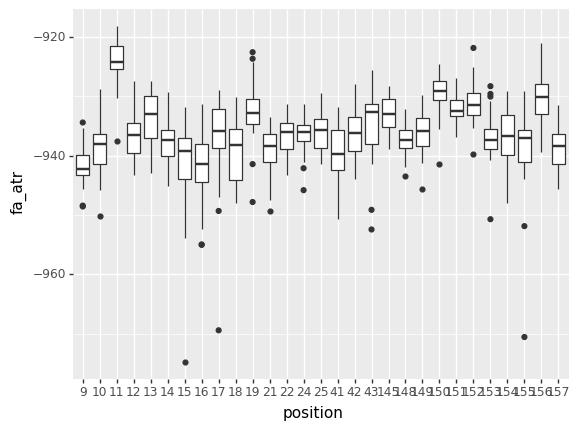

<ggplot: (8739121911337)>

In [38]:
(ggplot(data)
     + aes('position', 'fa_atr')
#     + aes(color='peptide')
#     + geom_point()
     + geom_boxplot()
#     + stat_smooth()
#     + facet_wrap('~sfxn')
#     + scale_x_log10()
)

In [43]:
def get_top(df, cat_column, sort_column, n):
    cc = set(df[cat_column])

    topl = []

    for c in cc:
        sd = df[(df[cat_column]==c)].sort_values(sort_column)
        topl.append(sd[:n])

    top = pd.concat(topl)
    
    return top

top = get_top(data, 'position', 'total_score', 5)

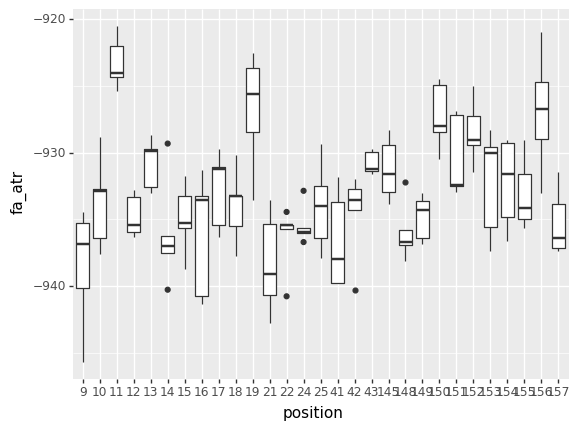

<ggplot: (8739194253677)>

In [48]:
(ggplot(top)
     + aes('position', 'fa_atr')
#     + aes(color='peptide')
#     + geom_point()
     + geom_boxplot()
#     + stat_smooth()
#     + facet_wrap('~sfxn')
#     + scale_x_log10()
)

In [60]:
s = top.std()['fa_atr']
a = top.mean()['fa_atr']
top['significant'] = (top['fa_atr'] > a+2*s) | (top['fa_atr'] < a-2*s)

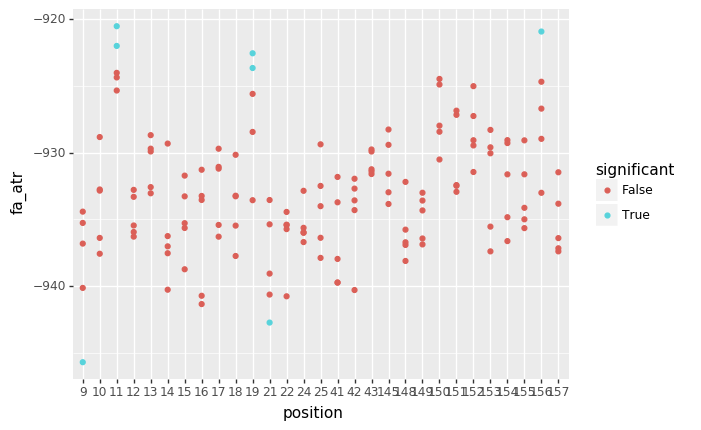

<ggplot: (8739020415357)>

In [61]:
(ggplot(top)
     + aes('position', 'fa_atr')
     + aes(color='significant')
     + geom_point()
#     + geom_boxplot()
#     + stat_smooth()
#     + facet_wrap('~sfxn')
#     + scale_x_log10()
)

Okay. I think this is working. Retry with a LOT more decoys.

In [64]:
from os import listdir
n_decoys = 125
interface_reps = interface * n_decoys
decoy_path = './decoys/A_scan_101/'
pdb_file = './smbits/peptide101.pdb'
work = [(pdb_file, r, decoy_path, i+725) for i, r in enumerate(interface_reps)]
print(len(work))
print(str(len(work)*2/22/60)+" hours")

3625
5.253623188405797 hours


In [ ]:
from multiprocessing import Pool
with Pool(processes=22) as p:
    p.starmap(ala_scan, work)